In [633]:
import numpy as np
import pandas as pd
import math

import statsmodels
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

import itertools
from scipy.stats import nbinom
from scipy.special import logsumexp

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

# Example from statsmodel docs

https://www.statsmodels.org/devel/examples/notebooks/generated/generic_mle.html

In [2]:
def _ll_nb2(y, X, beta, alph):
    mu = np.exp(np.dot(X, beta))
    size = 1/alph
    prob = size/(size+mu)
    ll = nbinom.logpmf(y, size, prob)
    # print(ll.shape, y.shape, prob.shape, size.shape)
    return ll

In [3]:
class NBin(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NBin, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        alph = params[-1]
        beta = params[:-1]
        ll = _ll_nb2(self.endog, self.exog, beta, alph)
        return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names.append('alpha')
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), 0.5)
            # intercept
            start_params[-2] = np.log(self.endog.mean())
        return super(NBin, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

In [4]:
medpar = sm.datasets.get_rdataset("medpar", "COUNT", cache=True).data

In [5]:
y = medpar.los
X = medpar[["type2", "type3", "hmo", "white"]].copy()
X["constant"] = 1

In [6]:
mod = NBin(y, X)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 3.209014
         Iterations: 805
         Function evaluations: 1238


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [7]:
print('Parameters: ', res.params)
print('Standard errors: ', res.bse)
print('P-values: ', res.pvalues)
print('AIC: ', res.aic)

Parameters:  [ 0.2212642   0.70613942 -0.06798155 -0.12903932  2.31026565  0.44575147]
Standard errors:  [0.05059259 0.07613047 0.05326095 0.06854137 0.06794697 0.01981542]
P-values:  [1.22298069e-005 1.76979353e-020 2.01818957e-001 5.97480106e-002
 2.15240570e-253 4.62688812e-112]
AIC:  9604.95320583016


In [8]:
print(res.summary())

                                 NBin Results                                 
Dep. Variable:                    los   Log-Likelihood:                -4797.5
Model:                           NBin   AIC:                             9605.
Method:            Maximum Likelihood   BIC:                             9632.
Date:                Sat, 09 Apr 2022                                         
Time:                        19:40:23                                         
No. Observations:                1495                                         
Df Residuals:                    1490                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
type2          0.2213      0.051      4.373      0.000       0.122       0.320
type3          0.7061      0.076      9.275      0.0

# Simulate mixture of negative binomials

In [9]:
tsv_file_dir = '/n/fs/ragr-data/users/palash/mskcc-analysis/panel2_normal_read_counts'
normal_tsv_file = 'RA17-37_39_1_IGO_12881_1/results/tsv/RA17-37_39_1_IGO_12881_1.tube1.barcode.cell.distribution.tsv'

df_tsv = pd.read_csv(f'{tsv_file_dir}/{normal_tsv_file}', sep='\t').set_index('cell_barcode')

In [1455]:
def simulate_mixed_NB(cell_total_reads, namplicon, nclones = 2, cn_max = 8, dispersion_parameter = 100, seed = 0):

    np.random.seed(seed)
    nobservations = len(cell_total_reads)
    amplicon_factors = np.random.dirichlet([1]*namplicon) / 2
    amplicon_idx = 0
    amplicon_factor = amplicon_factors[amplicon_idx]

    mixture_proportions = np.random.dirichlet([1]*nclones)
    cn_profiles = np.random.randint(cn_max - 1, size=nclones) + 1
    
    observed_read_counts = []
    clone_ids = []
    for total_reads in cell_total_reads:
        # clone_idx = np.random.randint(nclones)
        clone_idx = np.argmax(np.random.multinomial(1, mixture_proportions, size=1))

        clone_ids.append(clone_idx)

        copy_number = cn_profiles[clone_idx]
        mu = copy_number*amplicon_factor*total_reads
        nb_p = 1 - mu / (dispersion_parameter + mu)
        read_count_draw = np.random.negative_binomial(dispersion_parameter, nb_p)
        # read_count_draw = nbinom.rvs(dispersion_parameter, nb_p)
        observed_read_counts.append(read_count_draw)
    
    observed_read_counts = pd.Series(observed_read_counts, index = cell_total_reads.index)
    hidden_clone_ids = pd.Series(clone_ids, index = cell_total_reads.index)
    
    return observed_read_counts, hidden_clone_ids, cell_total_reads * amplicon_factor, cn_profiles, mixture_proportions

In [1461]:
cell_total_reads = df_tsv.sum(axis = 1)
nclones = 2
namplicon = 500
gt_phi = 25

observed_read_counts, hidden_clone_ids, total_reads, gt_cn_profiles, gt_mixing_proportions = simulate_mixed_NB(cell_total_reads, namplicon, nclones,
                                                                                                               dispersion_parameter=gt_phi, seed=2)

In [1462]:
observed_read_counts

cell_barcode
ACCGTCCTATCCTTCAAC-1     520
AGCAAGTCCAAGAGAGAG-1    1329
CGCACTCTTTGACCTCCT-1    1085
TCGTAGGAATCGACGTTG-1    1347
TTCCAGGAGCAATACCAC-1     406
                        ... 
CAGCACGTGTGGTGCCTG-1      26
GACCGGTAGTCCTTCGTA-1      35
CCGGATTGCGTGCGTTCC-1      23
AGATCGAGTTCTACAGTT-1       9
CAGTGAGGAGACCGTAGT-1      24
Length: 4286, dtype: int64

(array([  1.,   3.,  17.,  25.,  74., 118., 208., 274., 271., 242., 177.,
        148., 122.,  76.,  79.,  80.,  85., 126., 114., 135., 159., 161.,
        158., 160., 163., 149., 161., 111.,  98., 122.,  93.,  82.,  66.,
         56.,  37.,  35.,  20.,  20.,  13.,  16.,   8.,   4.,   9.,   3.,
          3.,   1.,   1.,   0.,   0.,   2.]),
 array([0.28430262, 0.47662632, 0.66895002, 0.86127372, 1.05359742,
        1.24592113, 1.43824483, 1.63056853, 1.82289223, 2.01521593,
        2.20753963, 2.39986333, 2.59218704, 2.78451074, 2.97683444,
        3.16915814, 3.36148184, 3.55380554, 3.74612925, 3.93845295,
        4.13077665, 4.32310035, 4.51542405, 4.70774775, 4.90007145,
        5.09239516, 5.28471886, 5.47704256, 5.66936626, 5.86168996,
        6.05401366, 6.24633737, 6.43866107, 6.63098477, 6.82330847,
        7.01563217, 7.20795587, 7.40027957, 7.59260328, 7.78492698,
        7.97725068, 8.16957438, 8.36189808, 8.55422178, 8.74654549,
        8.93886919, 9.13119289, 9.32351659, 9.

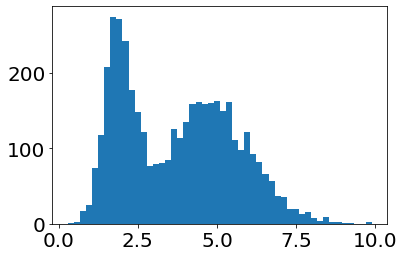

In [1463]:
plt.hist(observed_read_counts / total_reads, bins=50)

(array([  1.,   3.,  17.,  25.,  74., 118., 208., 274., 271., 242., 177.,
        148., 122.,  76.,  79.,  80.,  85., 126., 114., 135., 159., 161.,
        158., 160., 163., 149., 161., 111.,  98., 122.,  93.,  82.,  66.,
         56.,  37.,  35.,  20.,  20.,  13.,  16.,   8.,   4.,   9.,   3.,
          3.,   1.,   1.,   0.,   0.,   2.]),
 array([0.28430262, 0.47662632, 0.66895002, 0.86127372, 1.05359742,
        1.24592113, 1.43824483, 1.63056853, 1.82289223, 2.01521593,
        2.20753963, 2.39986333, 2.59218704, 2.78451074, 2.97683444,
        3.16915814, 3.36148184, 3.55380554, 3.74612925, 3.93845295,
        4.13077665, 4.32310035, 4.51542405, 4.70774775, 4.90007145,
        5.09239516, 5.28471886, 5.47704256, 5.66936626, 5.86168996,
        6.05401366, 6.24633737, 6.43866107, 6.63098477, 6.82330847,
        7.01563217, 7.20795587, 7.40027957, 7.59260328, 7.78492698,
        7.97725068, 8.16957438, 8.36189808, 8.55422178, 8.74654549,
        8.93886919, 9.13119289, 9.32351659, 9.

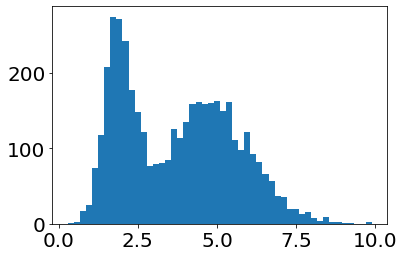

In [1464]:
plt.hist(observed_read_counts / total_reads, bins=50)

In [1460]:
gt_cn_profiles, gt_mixing_proportions

(array([5, 2]), array([0.57624724, 0.42375276]))

In [1221]:
hidden_clone_ids.value_counts()

1    2406
0    1880
dtype: int64

In [1222]:
fixed_cell_total_reads[0]*2

46520

# EM for mixture of negative binomials

In [1251]:
def get_responsibilities_and_marginal(y, mixing_props, cn, total_reads, phi):
    nobservations = len(y)
    nclones = len(cn)
    coeffs = np.zeros((nobservations, nclones))
    
    for clone_idx in range(nclones):
        mu = cn[clone_idx] * total_reads
        prob  = phi / (phi + mu)
        coeffs[:, clone_idx] = mixing_props[clone_idx] * nbinom.pmf(y, phi, prob)

    # marginal = np.sum(np.log(coeffs))
    marginal = np.sum(np.log(np.sum(coeffs, axis = 1)))
    responsibilities = coeffs / np.sum(coeffs, axis = 1)[:, np.newaxis]
    
    return responsibilities, marginal

In [1252]:
def _ll_mixture_nb(y, coeffs, cn, total_reads, phi):
    ll = 0
    nclones = len(cn)
    for clone_idx in range(nclones):
        mu = cn[clone_idx] * total_reads
        prob = phi / (phi + mu)
        ll += coeffs[:, clone_idx] * nbinom.logpmf(y, phi, prob)
    return ll

In [1253]:
class NBin_mixture_Q(GenericLikelihoodModel):
    def __init__(self, endog, coeffs, total_reads, seed=0, **kwds):
        super(NBin_mixture_Q, self).__init__(endog, exog = np.zeros(endog.shape), **kwds)
        self.coeffs = coeffs
        self.total_reads = total_reads
        self.nclones = coeffs.shape[1]
        self.seed = seed

    def nloglikeobs(self, params):
        phi = params[-1]
        cn = params[:-1]
        ll = _ll_mixture_nb(self.endog, self.coeffs, cn, self.total_reads, phi)
        return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        for clone_idx in range(self.nclones):
            self.exog_names.append(f'cn_clone_{clone_idx}')
        self.exog_names.append('phi')

        if start_params is None:
            # Reasonable starting values
            cn_guess = np.arange(self.nclones) + 1
            phi_guess = 100
            
            start_params = np.append(cn_guess, phi_guess)
        
        return super(NBin_mixture_Q, self).fit(start_params=start_params,
                                               maxiter=maxiter, maxfun=maxfun,
                                               **kwds)

In [1274]:
def mixed_NB_EM(y, total_reads, nclones=1, maxiter=10, seed=0, cn_max=8, tol = 1e-6):
    
    np.random.seed(seed)
    nobservations = len(y)
    
    # initial guess
    mixing_props = [1/nclones]*nclones
    cn = np.arange(nclones) + 1
    # cn = np.random.randint(cn_max - 1, size=nclones) + 1
    phi = 10
    relative_marginal_gain = np.inf
    old_marginal = -np.inf
    iter_count = 0
    em_data = []
    
    while (iter_count < maxiter) & (relative_marginal_gain >= tol):
    # while (iter_count < maxiter):
        
        # E-step
        coeffs, old_marginal = get_responsibilities_and_marginal(y, mixing_props, cn, total_reads, phi)
        
        # print(new_marginal, mixing_props)
        
        # M-step
        new_mixing_props = coeffs.sum(axis=0) / nobservations
        curr_model = NBin_mixture_Q(y, coeffs, total_reads, seed)
        # res = curr_model.fit(disp=0)
        
        res = curr_model.fit(start_params=np.append(cn, phi), disp=1)
        
        # optimization solution
        params = res.params
        new_cn = params[:nclones]
        new_phi = params[-1]
        
        # summary
        inner_iter = 0
        # inner_iter = res.mle_retvals['iterations']
        inner_converged = res.mle_retvals['converged']
        fopt = res.mle_retvals['fopt']
        fcalls = res.mle_retvals['fcalls']
        
        _, new_marginal = get_responsibilities_and_marginal(y, new_mixing_props, new_cn, total_reads, new_phi)        
        
        if iter_count > 0:
            # print(new_marginal, old_marginal, sep='\t')
            relative_marginal_gain = (new_marginal - old_marginal) / np.abs(old_marginal)
            
        em_data.append([iter_count, old_marginal, new_marginal, relative_marginal_gain, fopt, fcalls, inner_iter, inner_converged])
        
        if (relative_marginal_gain > 0) | (np.abs(new_marginal) == np.inf) | (np.abs(old_marginal) == np.inf):
            # old_marginal = new_marginal
            cn = new_cn
            phi = new_phi
            mixing_props = new_mixing_props
            
            iter_count += 1
            if np.isnan(relative_marginal_gain):
                relative_marginal_gain = np.inf
        else:
            break
        
    df_EM = pd.DataFrame(em_data, columns = ['iterations', 'old_marginal', 'marginal', 'relative_marginal_gain', 'fopt', 'fcalls', 'inner_iter', 'inner_converged'])
    
    return mixing_props, cn, phi, df_EM

In [1275]:
inferred_mixing_props, inferred_cn, inferred_phi, df_EM = mixed_NB_EM(observed_read_counts.values, total_reads.values, nclones=2, seed=0)

Optimization terminated successfully.
         Current function value: 4.042371
         Iterations: 82
         Function evaluations: 150


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


Optimization terminated successfully.
         Current function value: 3.736786
         Iterations: 82
         Function evaluations: 152


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


Optimization terminated successfully.
         Current function value: 3.535840
         Iterations: 103
         Function evaluations: 186


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


Optimization terminated successfully.
         Current function value: 3.512952
         Iterations: 77
         Function evaluations: 143


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


Optimization terminated successfully.
         Current function value: 3.511937
         Iterations: 76
         Function evaluations: 144


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


Optimization terminated successfully.
         Current function value: 3.511877
         Iterations: 74
         Function evaluations: 135


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


In [1276]:
df_EM

,iterations,old_marginal,marginal,relative_marginal_gain,fopt,fcalls,inner_iter,inner_converged
0,0,-20521.442954,-18821.912787,inf,4.042371,150,0,True
1,1,-18821.912787,-18123.701004,3.709569e-02,3.736786,152,0,True
2,2,-18123.701004,-17910.108551,1.178526e-02,3.535840,186,0,True
3,3,-17910.108551,-17906.851930,1.818314e-04,3.512952,143,0,True
4,4,-17906.851930,-17906.827095,1.386907e-06,3.511937,144,0,True
5,5,-17906.827095,-17906.826889,1.150280e-08,3.511877,135,0,True


In [1277]:
_, gt_marginal = get_responsibilities_and_marginal(observed_read_counts.values, gt_mixing_proportions, gt_cn_profiles, total_reads.values, gt_phi)

In [1278]:
df_EM

,iterations,old_marginal,marginal,relative_marginal_gain,fopt,fcalls,inner_iter,inner_converged
0,0,-20521.442954,-18821.912787,inf,4.042371,150,0,True
1,1,-18821.912787,-18123.701004,3.709569e-02,3.736786,152,0,True
2,2,-18123.701004,-17910.108551,1.178526e-02,3.535840,186,0,True
3,3,-17910.108551,-17906.851930,1.818314e-04,3.512952,143,0,True
4,4,-17906.851930,-17906.827095,1.386907e-06,3.511937,144,0,True
5,5,-17906.827095,-17906.826889,1.150280e-08,3.511877,135,0,True


In [1279]:
gt_marginal

-17908.04872150844

In [1280]:
inferred_cn

array([1.00093236, 2.98564627])

In [1281]:
inferred_mixing_props

array([0.43971281, 0.56028719])

In [1282]:
inferred_phi

99.6718493760109

In [1283]:
gt_cn_profiles

array([1, 3])

In [1284]:
gt_mixing_proportions

array([0.44320164, 0.55679836])

# EM for mixture of NB with fixed dispersion

In [1285]:
class NBin_mixture_Q_fixed_phi(GenericLikelihoodModel):
    def __init__(self, endog, coeffs, total_reads, phi, seed=0, **kwds):
        super(NBin_mixture_Q_fixed_phi, self).__init__(endog, exog = np.zeros(endog.shape), **kwds)
        self.coeffs = coeffs
        self.total_reads = total_reads
        self.nclones = coeffs.shape[1]
        self.seed = seed
        self.phi = phi

    def nloglikeobs(self, params):
        # phi = params[-1]
        cn = params
        ll = _ll_mixture_nb(self.endog, self.coeffs, cn, self.total_reads, self.phi)
        return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        for clone_idx in range(self.nclones):
            self.exog_names.append(f'cn_clone_{clone_idx}')

        if start_params is None:
            # Reasonable starting values
            cn_guess = np.arange(self.nclones) + 1
            start_params = cn_guess
        
        return super(NBin_mixture_Q_fixed_phi, self).fit(start_params=start_params,
                                               maxiter=maxiter, maxfun=maxfun,
                                               **kwds)

In [1335]:
def mixed_NB_EM_fixed_dispersion(y, total_reads, nclones=1, phi=100, cn_max=8, maxiter=10, seed=0, tol = 1e-6):
    
    np.random.seed(seed)
    nobservations = len(y)
    
    # initial guess
    mixing_props = [1/nclones]*nclones
    cn = np.arange(nclones) + 1
    # cn = np.random.randint(cn_max - 1, size=nclones) + 1

    relative_marginal_gain = np.inf
    old_marginal = np.inf
    iter_count = 0
    em_data = []
    
    while (iter_count < maxiter) & (relative_marginal_gain >= tol):
    # while (iter_count < maxiter):
        
        # E-step
        coeffs, new_marginal = get_responsibilities_and_marginal(y, mixing_props, cn, total_reads, phi)
        
        print(new_marginal, mixing_props)
        
        # M-step
        new_mixing_props = coeffs.sum(axis=0) / nobservations

        curr_model = NBin_mixture_Q_fixed_phi(y, coeffs, total_reads, phi, seed)
        # res = curr_model.fit(disp=0)
        
        res = curr_model.fit(start_params=cn, disp=0, xtol=1e-9, ftol=1e-9)
        
        # optimization solution
        params = res.params
        new_cn = params[:nclones]
        
        # summary
        inner_iter = 0
        # inner_iter = res.mle_retvals['iterations']
        inner_converged = res.mle_retvals['converged']
        fopt = res.mle_retvals['fopt']
        fcalls = res.mle_retvals['fcalls']
        
        if iter_count > 0:
            relative_marginal_gain = (new_marginal - old_marginal) / np.abs(old_marginal)
            
        em_data.append([iter_count, old_marginal, new_marginal, relative_marginal_gain, fopt, fcalls, inner_iter, inner_converged])
        
        if (relative_marginal_gain > 0) | (np.abs(new_marginal) == np.inf) | (np.abs(old_marginal) == np.inf):
            old_marginal = new_marginal
            cn = new_cn
            mixing_props = new_mixing_props
            
            iter_count += 1
            if np.isnan(relative_marginal_gain):
                relative_marginal_gain = np.inf
        else:
            break
        
    df_EM = pd.DataFrame(em_data, columns = ['iterations', 'old_marginal', 'marginal', 'relative_marginal_gain', 'fopt', 'fcalls', 'inner_iter', 'inner_converged'])
    
    return mixing_props, cn, phi, df_EM

In [1336]:
inferred_mixing_props, inferred_cn, inferred_phi, df_EM = mixed_NB_EM_fixed_dispersion(observed_read_counts.values, total_reads.values, phi=gt_phi, nclones=2, seed=0)

-31608.274570025376 [0.5, 0.5]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-20390.031333141815 [0.11342073 0.88657927]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-20187.691889455295 [0.17415421 0.82584579]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-20051.187965528938 [0.2267421 0.7732579]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-19964.816554479636 [0.27046284 0.72953716]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-19912.883933534664 [0.30522532 0.69477468]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-19882.485071352392 [0.33213898 0.66786102]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-19864.90117117243 [0.35270866 0.64729134]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-19854.769042579333 [0.3683469 0.6316531]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-19848.93005350441 [0.38021877 0.61978123]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


In [1337]:
_, gt_marginal = get_responsibilities_and_marginal(observed_read_counts.values, gt_mixing_proportions, gt_cn_profiles, total_reads.values, gt_phi)

In [1338]:
df_EM

,iterations,old_marginal,marginal,relative_marginal_gain,fopt,fcalls,inner_iter,inner_converged
0,0,inf,-31608.274570,inf,4.605612,142,0,True
1,1,-3.160827e+04,-20390.031333,0.354915,4.455247,126,0,True
2,2,-2.039003e+04,-20187.691889,0.009923,4.359866,128,0,True
3,3,-2.018769e+04,-20051.187966,0.006762,4.297101,124,0,True
4,4,-2.005119e+04,-19964.816554,0.004308,4.256800,132,0,True
5,5,-1.996482e+04,-19912.883934,0.002601,4.231536,129,0,True
6,6,-1.991288e+04,-19882.485071,0.001527,4.215849,128,0,True
7,7,-1.988249e+04,-19864.901171,0.000884,4.206090,118,0,True
8,8,-1.986490e+04,-19854.769043,0.000510,4.199960,120,0,True
9,9,-1.985477e+04,-19848.930054,0.000294,4.196054,125,0,True


In [1339]:
gt_marginal

-19841.264535145187

In [1291]:
inferred_cn

array([1.00072879, 2.98531297])

In [1292]:
inferred_mixing_props

array([0.43947043, 0.56052957])

In [1293]:
gt_cn_profiles

array([1, 3])

In [1294]:
gt_mixing_proportions

array([0.44320164, 0.55679836])

# EM for mixture of NB with fixed dispersion, fixed total cell counts

In [1295]:
nobservations = len(cell_total_reads)
fixed_cell_total_reads = pd.Series([math.floor(np.median(cell_total_reads))] * nobservations)

In [1296]:
nclones = 2
namplicon = 500
gt_phi = 10

observed_read_counts, hidden_clone_ids, total_reads, gt_cn_profiles, gt_mixing_proportions = simulate_mixed_NB(fixed_cell_total_reads, namplicon, nclones,
                                                                                                               dispersion_parameter=gt_phi, seed=2)

(array([ 21.,  28.,  77., 136., 263., 233., 261., 200., 199., 187., 213.,
        153., 134., 146., 180., 142., 120., 130., 144., 181., 130., 127.,
         91., 110., 116.,  77.,  89.,  57.,  51.,  58.,  38.,  31.,  37.,
         20.,  17.,  20.,  10.,  11.,   9.,   7.,  10.,   5.,   7.,   3.,
          0.,   0.,   3.,   1.,   1.,   2.]),
 array([ 0.36145912,  0.59279296,  0.8241268 ,  1.05546063,  1.28679447,
         1.51812831,  1.74946215,  1.98079598,  2.21212982,  2.44346366,
         2.67479749,  2.90613133,  3.13746517,  3.36879901,  3.60013284,
         3.83146668,  4.06280052,  4.29413436,  4.52546819,  4.75680203,
         4.98813587,  5.21946971,  5.45080354,  5.68213738,  5.91347122,
         6.14480506,  6.37613889,  6.60747273,  6.83880657,  7.07014041,
         7.30147424,  7.53280808,  7.76414192,  7.99547575,  8.22680959,
         8.45814343,  8.68947727,  8.9208111 ,  9.15214494,  9.38347878,
         9.61481262,  9.84614645, 10.07748029, 10.30881413, 10.54014797,
 

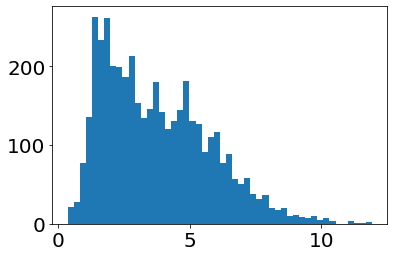

In [1297]:
plt.hist(observed_read_counts / total_reads, bins=50)

In [1298]:
gt_cn_profiles

array([5, 2])

In [1299]:
_, gt_marginal = get_responsibilities_and_marginal(observed_read_counts.values, gt_mixing_proportions, gt_cn_profiles, total_reads, gt_phi)

In [1300]:
gt_marginal

-19841.264535145187

In [1326]:
def mixed_NB_EM_fixed_dispersion_fixed_total_cell_count(y, total_reads, nclones=1, phi=100, cn_max=8, maxiter=10, seed=0, tol = 1e-8):
    
    np.random.seed(seed)
    nobservations = len(y)
    
    fixed_total_reads = total_reads[0]
    print(fixed_total_reads)
    # initial guess
    mixing_props = [1/nclones]*nclones
    # cn = np.arange(nclones) + 1
    cn = np.random.randint(cn_max - 1, size=nclones) + 1

    relative_marginal_gain = np.inf
    old_marginal = np.inf
    iter_count = 0
    em_data = []
    
    while (iter_count < maxiter) & (relative_marginal_gain >= tol):
    # while (iter_count < maxiter):
        
        # E-step
        coeffs, new_marginal = get_responsibilities_and_marginal(y, mixing_props, cn, total_reads, phi)
        
        print(new_marginal, cn, mixing_props)
        
        # M-step
        new_mixing_props = coeffs.sum(axis=0) / nobservations
        new_cn = (coeffs * y[:, np.newaxis]).sum(axis=0) / (coeffs * total_reads[:, np.newaxis]).sum(axis=0)
        
        _, new_marginal = get_responsibilities_and_marginal(y, new_mixing_props, new_cn, total_reads, phi)                
        
        if iter_count > 0:
            relative_marginal_gain = (new_marginal - old_marginal) / np.abs(old_marginal)
            
        em_data.append([iter_count, old_marginal, new_marginal, relative_marginal_gain])
        
        if (relative_marginal_gain > 0) | (np.abs(new_marginal) == np.inf) | (np.abs(old_marginal) == np.inf):
            old_marginal = new_marginal
            cn = new_cn
            mixing_props = new_mixing_props
            
            iter_count += 1
            if np.isnan(relative_marginal_gain):
                relative_marginal_gain = np.inf
        else:
            break
        
    df_EM = pd.DataFrame(em_data, columns = ['iterations', 'old_marginal', 'marginal', 'relative_marginal_gain'])
    
    return mixing_props, cn, phi, df_EM

In [1327]:
inferred_mixing_props, inferred_cn, inferred_phi, df_EM = mixed_NB_EM_fixed_dispersion_fixed_total_cell_count(observed_read_counts.values,
                                                                                       total_reads.values, phi=gt_phi, nclones=2, seed=0)

13.832822885142983
-23402.704068344337 [5 6] [0.5, 0.5]
-20824.174513375667 [3.3099804 4.4678723] [0.61676351 0.38323649]
-20297.46633065077 [2.91461701 5.05942329] [0.60877128 0.39122872]
-20038.453277814915 [2.59444669 5.43865057] [0.5924061 0.4075939]
-19959.91047019464 [2.42625775 5.4815827 ] [0.56552279 0.43447721]
-19917.093117609635 [2.32604838 5.41091062] [0.53719864 0.46280136]
-19888.881389709637 [2.2533385  5.33045052] [0.51240373 0.48759627]
-19870.56148677344 [2.19710642 5.26138782] [0.49201127 0.50798873]
-19858.978459666356 [2.15329324 5.20559857] [0.47566399 0.52433601]
-19851.805339278904 [2.11930087 5.16144938] [0.46273959 0.53726041]


In [1328]:
df_EM

,iterations,old_marginal,marginal,relative_marginal_gain
0,0,inf,-20824.174513,inf
1,1,-2.082417e+04,-20297.466331,0.025293
2,2,-2.029747e+04,-20038.453278,0.012761
3,3,-2.003845e+04,-19959.910470,0.003920
4,4,-1.995991e+04,-19917.093118,0.002145
5,5,-1.991709e+04,-19888.881390,0.001416
6,6,-1.988888e+04,-19870.561487,0.000921
7,7,-1.987056e+04,-19858.978460,0.000583
8,8,-1.985898e+04,-19851.805339,0.000361
9,9,-1.985181e+04,-19847.429101,0.000220


In [1329]:
_, gt_marginal = get_responsibilities_and_marginal(observed_read_counts.values, gt_mixing_proportions, gt_cn_profiles, total_reads.values, gt_phi)

In [1330]:
gt_marginal

-19841.264535145187

In [1331]:
inferred_cn

array([2.0930494 , 5.12687044])

In [1332]:
inferred_phi

10

In [1333]:
inferred_mixing_props

array([0.45261193, 0.54738807])

In [1334]:
gt_cn_profiles

array([5, 2])

In [1325]:
gt_mixing_proportions

array([0.57624724, 0.42375276])

# Simulate gene-level read counts

In [287]:
tsv_file_dir = '/n/fs/ragr-data/users/palash/mskcc-analysis/panel2_normal_read_counts'
normal_tsv_file = 'RA17-37_39_1_IGO_12881_1/results/tsv/RA17-37_39_1_IGO_12881_1.tube1.barcode.cell.distribution.tsv'

df_tsv = pd.read_csv(f'{tsv_file_dir}/{normal_tsv_file}', sep='\t').set_index('cell_barcode')

In [288]:
def simulate_mixed_NB_gene_level(cell_total_reads, gene_namplicon = 10, namplicon = 500, nclones = 2, cn_max = 8, seed = 0):

    np.random.seed(seed)
    nobservations = len(cell_total_reads)
    amplicon_factors = np.random.dirichlet([1]*namplicon) / 2

    dispersion_parameters = np.random.randint(10, size=gene_namplicon) + 1
    # dispersion_parameters = np.array([100]*gene_namplicon)
    
    mixture_proportions = np.random.dirichlet([1]*nclones)
    cn_profiles = np.random.randint(cn_max - 1, size=nclones) + 1
    
    observed_read_counts = []
    clone_ids = []
    for total_reads in cell_total_reads:
        # clone_idx = np.random.randint(nclones)
        clone_idx = np.argmax(np.random.multinomial(1, mixture_proportions, size=1))

        clone_ids.append(clone_idx)
        copy_number = cn_profiles[clone_idx]

        cell_observed_read_counts = []
        for amplicon_idx in range(gene_namplicon):
            
            mu = copy_number*amplicon_factors[amplicon_idx]*total_reads
            nb_p = 1 - mu / (dispersion_parameters[amplicon_idx] + mu)
            read_count_draw = np.random.negative_binomial(dispersion_parameters[amplicon_idx], nb_p)
            # read_count_draw = nbinom.rvs(dispersion_parameter, nb_p)
            cell_observed_read_counts.append(read_count_draw)
            
        observed_read_counts.append(cell_observed_read_counts)

            
    df_observed_read_counts = pd.DataFrame(observed_read_counts, index = cell_total_reads.index, columns = [f'amplicon_{idx}' for idx in range(gene_namplicon)])
    hidden_clone_ids = pd.Series(clone_ids, index = cell_total_reads.index)
    df_simulated_amplicons = pd.DataFrame({'amplicon': [f'amplicon_{idx}' for idx in range(gene_namplicon)],
                                           'amplicon_factor': list(amplicon_factors[:gene_namplicon]),
                                           'phi': list(dispersion_parameters)})
    
    return df_observed_read_counts, hidden_clone_ids, cn_profiles, mixture_proportions, df_simulated_amplicons.set_index('amplicon')

In [332]:
cell_total_reads = df_tsv.sum(axis = 1)
nclones = 2
namplicon = 500
gene_namplicon = 5

df_observed_read_counts, hidden_clone_ids, gt_cn, gt_mixture_proportions, df_simulated_amplicons = simulate_mixed_NB_gene_level(cell_total_reads, gene_namplicon,
                                                                                                                                nclones = nclones, seed=0)

In [333]:
df_observed_read_counts

,amplicon_0,amplicon_1,amplicon_2,amplicon_3,amplicon_4
cell_barcode,,,,,
ACCGTCCTATCCTTCAAC-1,1839,2040,446,1614,238
AGCAAGTCCAAGAGAGAG-1,1699,3542,1720,2170,1628
CGCACTCTTTGACCTCCT-1,2280,5007,3529,434,772
TCGTAGGAATCGACGTTG-1,1474,4648,720,1656,621
TTCCAGGAGCAATACCAC-1,743,2499,1862,1025,667
...,...,...,...,...,...
CAGCACGTGTGGTGCCTG-1,78,178,58,55,59
GACCGGTAGTCCTTCGTA-1,32,122,104,4,50
CCGGATTGCGTGCGTTCC-1,55,93,70,25,23


In [334]:
gt_cn

array([4, 7])

In [335]:
gt_mixture_proportions

array([0.1048033, 0.8951967])

# EM for mixture of NB with fixed dispersion at gene level

In [336]:
def get_responsibilities_and_marginal_gene_level(df_observed_read_counts, df_gene_amplicons, cell_total_reads, mixing_props, cn):    
    ncells = len(df_observed_read_counts)
    nclones = len(cn)

    coeffs = np.zeros((ncells, nclones))    
    
    for clone_idx in range(nclones):
        mu = cn[clone_idx] * cell_total_reads.values[:, np.newaxis] * df_gene_amplicons['amplicon_factor'].values[np.newaxis, :]
        phi_matrix = np.array([1]*ncells)[:, np.newaxis] * df_gene_amplicons['phi'].values[np.newaxis, :]

        prob = phi_matrix / (phi_matrix + mu)
        coeff_ij = nbinom.pmf(df_observed_read_counts.values, phi_matrix, prob)

        coeffs[:, clone_idx] =  mixing_props[clone_idx] * np.prod(coeff_ij, axis=1)    
        
    marginal = np.sum(np.log(np.sum(coeffs, axis = 1)))
    responsibilities = coeffs / np.sum(coeffs, axis = 1)[:, np.newaxis]        
    
    return responsibilities, marginal

In [337]:
def _ll_mixture_nb_gene_level(responsibilities, df_observed_read_counts, df_gene_amplicons, cell_total_reads, cn):
    ll = 0
    ncells = len(df_observed_read_counts)
    nclones = len(cn)
    for clone_idx in range(nclones):
        mu = cn[clone_idx] * cell_total_reads.values[:, np.newaxis] * df_gene_amplicons['amplicon_factor'].values[np.newaxis, :]
        phi_matrix = np.array([1]*ncells)[:, np.newaxis] * df_gene_amplicons['phi'].values[np.newaxis, :]

        prob = phi_matrix / (phi_matrix + mu)

        ll += responsibilities[:, clone_idx] * np.sum(nbinom.logpmf(df_observed_read_counts.values, phi_matrix, prob), axis=1)
    
    return ll

In [338]:
class NBin_mixture_Q_fixed_phi_gene_level(GenericLikelihoodModel):
    def __init__(self, endog, responsibilities, df_observed_read_counts, df_gene_amplicons, cell_total_reads, seed=0, **kwds):
        super(NBin_mixture_Q_fixed_phi_gene_level, self).__init__(endog, exog = [0], **kwds)
        self.responsibilities = responsibilities
        self.cell_total_reads = cell_total_reads
        self.nclones = responsibilities.shape[1]
        self.df_observed_read_counts = df_observed_read_counts
        self.df_gene_amplicons = df_gene_amplicons
        self.seed = seed

    def nloglikeobs(self, params):
        # phi = params[-1]
        cn = params
        ll = _ll_mixture_nb_gene_level(self.responsibilities, self.df_observed_read_counts, self.df_gene_amplicons, self.cell_total_reads, cn)
        return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        for clone_idx in range(self.nclones):
            self.exog_names.append(f'cn_clone_{clone_idx}')

        if start_params is None:
            # Reasonable starting values
            cn_guess = np.arange(self.nclones) + 1
            start_params = cn_guess
        
        return super(NBin_mixture_Q_fixed_phi_gene_level, self).fit(start_params=start_params, maxiter=maxiter, maxfun=maxfun, **kwds)

In [339]:
def mixed_NB_EM_fixed_dispersion_gene_level(df_observed_read_counts, df_gene_amplicons, cell_total_reads, nclones=1, cn_max=8, maxiter=20, seed=0, tol = 1e-6):
    
    np.random.seed(seed)
    ncells = len(df_observed_read_counts)
    
    # initial guess
    mixing_props = [1/nclones]*nclones
    # cn = np.arange(nclones) + 1
    cn = np.random.randint(cn_max - 1, size=nclones) + 1

    relative_marginal_gain = np.inf
    old_marginal = np.inf
    iter_count = 0
    em_data = []
    
    while (iter_count < maxiter) & (relative_marginal_gain >= tol):
    # while (iter_count < maxiter):
        
        # E-step
        responsibilities, new_marginal = get_responsibilities_and_marginal_gene_level(df_observed_read_counts, df_gene_amplicons, cell_total_reads,
                                                                            mixing_props, cn)
        
        print(new_marginal, mixing_props)
        
        # M-step
        new_mixing_props = responsibilities.sum(axis=0) / ncells

        curr_model = NBin_mixture_Q_fixed_phi_gene_level([1], responsibilities, df_observed_read_counts, df_gene_amplicons, cell_total_reads, seed)
        # res = curr_model.fit(disp=0)
        
        res = curr_model.fit(start_params=cn, disp=0)
        
        # optimization solution
        params = res.params
        new_cn = params[:nclones]
        
        # summary
        inner_iter = 0
        # inner_iter = res.mle_retvals['iterations']
        inner_converged = res.mle_retvals['converged']
        fopt = res.mle_retvals['fopt']
        fcalls = res.mle_retvals['fcalls']
        
        if iter_count > 0:
            relative_marginal_gain = (new_marginal - old_marginal) / np.abs(old_marginal)
            
        em_data.append([iter_count, old_marginal, new_marginal, relative_marginal_gain, fopt, fcalls, inner_iter, inner_converged])
        
        if (relative_marginal_gain > 0) | (np.abs(new_marginal) == np.inf) | (np.abs(old_marginal) == np.inf):
            old_marginal = new_marginal
            cn = new_cn
            mixing_props = new_mixing_props
            
            iter_count += 1
            if np.isnan(relative_marginal_gain):
                relative_marginal_gain = np.inf
        else:
            break
        
    df_EM = pd.DataFrame(em_data, columns = ['iterations', 'old_marginal', 'marginal', 'relative_marginal_gain', 'fopt', 'fcalls', 'inner_iter', 'inner_converged'])
    
    return mixing_props, cn, df_EM

In [340]:
inferred_mixing_props, inferred_cn, df_EM = mixed_NB_EM_fixed_dispersion_gene_level(df_observed_read_counts, df_simulated_amplicons, cell_total_reads, nclones=2, seed=10)

-125355.08312357026 [0.5, 0.5]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121712.23024355741 [0.02462964 0.97537036]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121618.15412790104 [0.04387312 0.95612688]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121569.65166940815 [0.06155939 0.93844061]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121546.64865271046 [0.07512319 0.92487681]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121535.83293893182 [0.08488479 0.91511521]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121530.61316057487 [0.09181022 0.90818978]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121528.00746560984 [0.09675056 0.90324944]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121526.66878880991 [0.10031338 0.89968662]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121525.96481687855 [0.10290735 0.89709265]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121525.5875049177 [0.10480986 0.89519014]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121525.38300662761 [0.10621577 0.89378423]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-121525.27084371235 [0.10725747 0.89274253]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


In [304]:
df_EM

,iterations,old_marginal,marginal,relative_marginal_gain,fopt,fcalls,inner_iter,inner_converged
0,0,inf,-123636.612981,inf,121180.111120,64,0,True
1,1,-1.236366e+05,-121744.620621,0.015303,120897.416825,57,0,True
2,2,-1.217446e+05,-121705.463407,0.000322,120732.681295,56,0,True
3,3,-1.217055e+05,-121684.542847,0.000172,120646.558009,53,0,True
4,4,-1.216845e+05,-121667.424734,0.000141,120596.390835,54,0,True
5,5,-1.216674e+05,-121650.592164,0.000138,120560.775123,59,0,True
6,6,-1.216506e+05,-121633.673739,0.000139,120531.768863,55,0,True
7,7,-1.216337e+05,-121616.898455,0.000138,120507.004713,59,0,True
8,8,-1.216169e+05,-121600.668159,0.000133,120486.191281,57,0,True
9,9,-1.216007e+05,-121585.434135,0.000125,120469.586120,56,0,True


In [305]:
inferred_mixing_props

array([0.1168837, 0.8831163])

In [306]:
inferred_cn

array([4.02004757, 7.01643948])

In [307]:
gt_mixture_proportions

array([0.1048033, 0.8951967])

In [308]:
gt_cn

array([4, 7])

# EM on a real data case

In [1723]:
df_simulated_amplicons

,amplicon_factor,phi
amplicon,,
amplicon_0,0.000029,1
amplicon_1,0.000270,4
amplicon_2,0.002238,5
amplicon_3,0.003229,3
amplicon_4,0.000260,6


In [1755]:
df_observed_read_counts.values.shape

(1955, 21)

In [1730]:
df_tsv = pd.read_csv('/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22_panel2/old_pipeline/RA17_22_35_1_IGO_12742_2/results/tsv/RA17_22_35_1_IGO_12742_2.tube1.barcode.cell.distribution.tsv', sep='\t', index_col = 0)
df_nb_residual = pd.read_csv('/n/fs/ragr-data/users/palash/mskcc-analysis/panel2_normal_read_counts/panel2_nb_results.csv', index_col = 0)
df_nb_residual['phi'] = 1 / df_nb_residual['alpha']
curr_gene = 'ARID1A'
nclones = 2

In [1759]:
df_clone_info = pd.DataFrame({'clone_id': list(np.arange(nclones)),
                              'cn': list(inferred_cn),
                              'props': list(inferred_mixing_props)})

In [1760]:
df_clone_info

,clone_id,cn,props
0,0,1.889991,0.601363
1,1,2.606450,0.398637


In [1758]:
inferred_cn

array([1.88999113, 2.60644992])

In [1731]:
curr_selected_amplicons = list(df_nb_residual[df_nb_residual['gene'] == curr_gene].index)
df_observed_read_counts = df_tsv[curr_selected_amplicons]
cell_total_read_counts = df_tsv.sum(axis = 1)
df_selected_amplicons = df_nb_residual.loc[curr_selected_amplicons][['amplicon_factor', 'phi']]

In [1779]:
inferred_mixing_props, inferred_cn, df_EM = mixed_NB_EM_fixed_dispersion_gene_level(df_observed_read_counts, df_selected_amplicons, cell_total_read_counts,
                                                                                    nclones=nclones, seed=0)

-223222.34056489923 [0.5, 0.5]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-195118.81705213734 [0.99454044 0.00545956]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194950.86035640794 [0.97526875 0.02473125]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194891.87432655354 [0.94906715 0.05093285]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194849.16629967128 [0.9241899 0.0758101]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194814.9643628843 [0.89833695 0.10166305]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194787.41734981223 [0.87238652 0.12761348]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194764.87851856835 [0.84687791 0.15312209]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194746.0540791094 [0.82201356 0.17798644]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194730.01040716624 [0.7978527 0.2021473]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194716.08788416808 [0.77439589 0.22560411]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194703.84407358113 [0.75161074 0.24838926]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194692.9421783168 [0.72950199 0.27049801]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194683.13545563887 [0.70803806 0.29196194]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194674.22789617628 [0.6871925 0.3128075]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194666.0801462205 [0.66692144 0.33307856]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194658.5758572845 [0.64721501 0.35278499]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194651.60632874334 [0.62805103 0.37194897]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194645.1080744103 [0.60936616 0.39063384]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194638.9969032487 [0.59117875 0.40882125]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


In [1771]:
inferred_mixing_props, inferred_cn, df_EM = mixed_NB_EM_fixed_dispersion_gene_level(df_observed_read_counts, df_selected_amplicons, cell_total_read_counts,
                                                                                    nclones=nclones, seed=0)

-223222.34056489923 [0.5, 0.5]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-195118.81705213734 [0.99454044 0.00545956]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194950.86035640794 [0.97526875 0.02473125]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194891.87432655354 [0.94906715 0.05093285]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194849.16629967128 [0.9241899 0.0758101]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194814.9643628843 [0.89833695 0.10166305]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194787.41734981223 [0.87238652 0.12761348]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194764.87851856835 [0.84687791 0.15312209]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194746.0540791094 [0.82201356 0.17798644]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194730.01040716624 [0.7978527 0.2021473]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194716.08788416808 [0.77439589 0.22560411]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194703.84407358113 [0.75161074 0.24838926]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194692.9421783168 [0.72950199 0.27049801]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194683.13545563887 [0.70803806 0.29196194]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194674.22789617628 [0.6871925 0.3128075]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194666.0801462205 [0.66692144 0.33307856]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194658.5758572845 [0.64721501 0.35278499]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194651.60632874334 [0.62805103 0.37194897]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194645.1080744103 [0.60936616 0.39063384]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194638.9969032487 [0.59117875 0.40882125]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


In [1772]:
2 * np.prod(df_observed_read_counts.values.shape) - 2 * df_EM.iloc[-1]['marginal']

471387.9938064974

In [1781]:
inferred_mixing_props, inferred_cn, df_EM = mixed_NB_EM_fixed_dispersion_gene_level(df_observed_read_counts, df_selected_amplicons, cell_total_read_counts,
                                                                                    nclones=1, seed=0)

-221878.02707705088 [1.0]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-195189.5742318573 [1.]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-195189.5742318573 [1.]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


In [1782]:
df_EM.iloc[-1]['marginal']

-195189.5742318573

In [1783]:
np.prod(df_observed_read_counts.values.shape)

41055

In [1785]:
np.log(np.prod(df_observed_read_counts.values.shape))

10.622667910142889

In [1784]:
 1 * np.log(np.prod(df_observed_read_counts.values.shape)) - 2 * df_EM.iloc[-1]['marginal']

390389.7711316247

In [1775]:
inferred_mixing_props, inferred_cn, df_EM = mixed_NB_EM_fixed_dispersion_gene_level(df_observed_read_counts, df_selected_amplicons, cell_total_read_counts,
                                                                                    nclones=3, seed=0)

-213894.81486617768 [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")
/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194577.07363007276 [0.60501113 0.00479093 0.39019794]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194529.82823056023 [0.62834616 0.00713784 0.364516  ]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194499.95064857014 [0.63919641 0.01491581 0.34588779]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194481.91444071126 [0.65475616 0.02110574 0.3241381 ]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194464.25894123115 [0.67314871 0.02604295 0.30080834]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194445.75650260953 [0.69237283 0.03065612 0.27697105]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194426.05656697613 [0.71177414 0.03520965 0.25301621]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194405.07672464594 [0.730851   0.03983935 0.22930965]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194383.05422378326 [0.74905231 0.04465232 0.20629536]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194360.65915724254 [0.76575862 0.04973072 0.18451066]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194339.011103076 [0.78031682 0.05513726 0.16454591]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194319.4703679924 [0.7921549  0.06091206 0.14693304]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194303.10986949864 [0.80091414 0.0670567  0.13202915]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194290.3218475281 [0.80655668 0.07353881 0.1199045 ]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194280.8166921739 [0.80936316 0.08027491 0.11036193]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194273.93423984345 [0.80979748 0.08716249 0.10304003]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194268.9488155443 [0.80840406 0.09407547 0.09752046]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194265.26849547634 [0.80570984 0.10090129 0.09338887]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


-194262.47513873497 [0.80217487 0.10753801 0.09028712]


/n/fs/ragr-data/users/palash/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1024: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)


In [1776]:
 3 * np.prod(df_observed_read_counts.values.shape) - 2 * df_EM.iloc[-1]['marginal']

511689.95027746994

# Brute Force

In [9]:
def get_responsibilities_and_marginal_gene_level(df_observed_read_counts, df_gene_amplicons, cell_total_reads, mixing_props, cn):    
    ncells = len(df_observed_read_counts)
    nclones = len(cn)

    coeffs = np.zeros((ncells, nclones))    
    
    for clone_idx in range(nclones):
        mu = cn[clone_idx] * cell_total_reads.values[:, np.newaxis] * df_gene_amplicons['amplicon_factor'].values[np.newaxis, :]
        phi_matrix = np.array([1]*ncells)[:, np.newaxis] * df_gene_amplicons['phi'].values[np.newaxis, :]
        prob = phi_matrix / (phi_matrix + mu)
        coeff_ij = nbinom.pmf(df_observed_read_counts.values, phi_matrix, prob)

        coeffs[:, clone_idx] =  mixing_props[clone_idx] * np.prod(coeff_ij, axis=1)    
        
    marginal = np.sum(np.log(np.sum(coeffs, axis = 1)))
    responsibilities = coeffs / np.sum(coeffs, axis = 1)[:, np.newaxis]        
    
    return responsibilities, marginal


In [10]:
def get_cn_string(cn_list, max_cn):
    cn_string = ['0']*(max_cn+1)
    for cn in cn_list:
        cn_string[cn] = '1'    
    return ''.join(cn_string)

In [11]:
tumor_tsv_file_dict = {'primary1': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22_panel2/old_pipeline/RA17_22_32_1_IGO_12742_B_2/results/tsv/RA17_22_32_1_IGO_12742_B_2.tube1.barcode.cell.distribution.tsv',
                       'primary2': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22_panel2/old_pipeline/RA17_22_35_1_IGO_12742_2/results/tsv/RA17_22_35_1_IGO_12742_2.tube1.barcode.cell.distribution.tsv',
                       'liver': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22_panel2/old_pipeline/RA17_22_39_6_IGO_12742_1/results/tsv/RA17_22_39_6_IGO_12742_1.tube1.barcode.cell.distribution.tsv',
                       'lung': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22_panel2/old_pipeline/RA17_22_06_2_IGO_12742_C_2/results/tsv/RA17_22_06_2_IGO_12742_C_2.tube1.barcode.cell.distribution.tsv',
                       'retroperitoneum': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22_panel2/old_pipeline/RA17_22_42_2_IGO_12742_C_1/results/tsv/RA17_22_42_2_IGO_12742_C_1.tube1.barcode.cell.distribution.tsv',
                       'peritoneum': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22_panel2/old_pipeline/RA17_22_27_2_IGO_12742_B_1/results/tsv/RA17_22_27_2_IGO_12742_B_1.tube1.barcode.cell.distribution.tsv',
                       'diaphragm': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22_panel2/old_pipeline/RA17_22-11_1/RA17_22_11_1_IGO_12742_D_2.barcode.cell.distribution.merged.tsv',
                       'primary3': '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22_panel2/old_pipeline/RA17_22_33_2/RA17_22_33_2_IGO_12742_D_1.barcode.cell.distribution.merged.tsv' }

In [12]:
cn_list

(1, 2)

In [13]:
mixing_props

array([0.06094251, 0.93905749])

In [14]:
df_cn_info = pd.DataFrame({'cn': cn_list[::-1], 'props': mixing_props})

In [15]:
df_cn_info

,cn,props
0,2,0.060943
1,1,0.939057


In [16]:
df_cn_info.sort_values('cn')

,cn,props
1,1,0.939057
0,2,0.060943


In [21]:
# prepare the input data
seed = 0
np.random.seed(seed)
sample = 'primary1'
df_tsv = pd.read_csv(tumor_tsv_file_dict[sample], sep='\t', index_col = 0)
df_nb_residual = pd.read_csv('/n/fs/ragr-data/users/palash/mskcc-analysis/panel2_normal_read_counts/panel2_nb_results.csv', index_col = 0)
df_nb_residual['phi'] = 1 / df_nb_residual['alpha']
curr_gene = 'ARID1A'

curr_selected_amplicons = list(df_nb_residual[df_nb_residual['gene'] == curr_gene].index)
df_observed_read_counts = df_tsv[curr_selected_amplicons]
cell_total_read_counts = df_tsv.sum(axis = 1)
df_selected_amplicons = df_nb_residual.loc[curr_selected_amplicons][['amplicon_factor', 'phi']]

# enumerate all possible combination of copy number clones
max_cn = 4
max_nclones = 5
ncells = len(df_observed_read_counts)

# multiple restarts of EM
nsamples = np.prod(df_observed_read_counts.values.shape)
nrestarts = 10
seed_list = np.random.permutation(np.arange(100))[:nrestarts]
tol = 1e-6
maxiter = 20
cn_list_idx = 0
result_data = []

for nclones in range(1, max_nclones+1):
    for cn_list in itertools.combinations(np.arange(max_cn+1), nclones):
        prop_string = ''
        cn_string = get_cn_string(cn_list, max_cn)
        final_mixing_props = [None]
        for restart_idx in range(nrestarts):
            np.random.seed(seed_list[restart_idx])

            # initial guess
            mixing_props = np.random.dirichlet([1]*nclones)

            relative_marginal_gain = np.inf
            old_marginal = -np.inf
            iter_count = 0
            em_data = []
            max_marginal = -np.inf

            while (iter_count < maxiter) & (relative_marginal_gain >= tol):
                responsibilities, new_marginal = get_responsibilities_and_marginal_gene_level(df_observed_read_counts, df_selected_amplicons, cell_total_read_counts,
                                                                                              mixing_props, cn_list)
                new_mixing_props = responsibilities.sum(axis=0) / ncells

                if iter_count > 0:
                    relative_marginal_gain = (new_marginal - old_marginal) / np.abs(old_marginal)

                em_data.append([sample, curr_gene, nclones,
                                iter_count, old_marginal, new_marginal, relative_marginal_gain])

                if (relative_marginal_gain > 0) | (np.abs(new_marginal) == np.inf) | (np.abs(old_marginal) == np.inf):
                    old_marginal = new_marginal
                    mixing_props = new_mixing_props

                    iter_count += 1
                    if np.isnan(relative_marginal_gain):
                        relative_marginal_gain = np.inf
                else:
                    break

            df_EM = pd.DataFrame(em_data, columns = ['sample', 'gene', 'nclones',
                                                     'iterations', 'old_marginal', 'marginal', 'relative_marginal_gain'])

            curr_max_marginal = df_EM.iloc[-1]['marginal']

            if curr_max_marginal > max_marginal:
                final_df_EM = df_EM
                final_mixing_props = mixing_props
                final_cn = cn_list
                max_marginal = curr_max_marginal

        prop_string = '|'.join(map(str, final_mixing_props))

        bic = 2 * nclones * np.log(nsamples) - 2 * max_marginal
        aic = 2 * 2 * nclones - 2 * max_marginal
        result_data.append([sample, curr_gene, nclones, seed, cn_string, prop_string, max_marginal, bic, aic])

# write the output
# prefix = args.prefix

df_result = pd.DataFrame(result_data,
                         columns = ['sample', 'gene', 'nclones', 'seed',
                                    'cn_string', 'prop_string', 'marginal', 'BIC', 'AIC'])

/tmp/ipykernel_41549/1994200555.py:15: RuntimeWarning: divide by zero encountered in log
  marginal = np.sum(np.log(np.sum(coeffs, axis = 1)))
/tmp/ipykernel_41549/1994200555.py:16: RuntimeWarning: invalid value encountered in true_divide
  responsibilities = coeffs / np.sum(coeffs, axis = 1)[:, np.newaxis]
/tmp/ipykernel_41549/1994200555.py:15: RuntimeWarning: divide by zero encountered in log
  marginal = np.sum(np.log(np.sum(coeffs, axis = 1)))
/tmp/ipykernel_41549/1994200555.py:16: RuntimeWarning: invalid value encountered in true_divide
  responsibilities = coeffs / np.sum(coeffs, axis = 1)[:, np.newaxis]
/tmp/ipykernel_41549/1994200555.py:15: RuntimeWarning: divide by zero encountered in log
  marginal = np.sum(np.log(np.sum(coeffs, axis = 1)))
/tmp/ipykernel_41549/1994200555.py:16: RuntimeWarning: invalid value encountered in true_divide
  responsibilities = coeffs / np.sum(coeffs, axis = 1)[:, np.newaxis]
/tmp/ipykernel_41549/1994200555.py:15: RuntimeWarning: divide by zero enc

In [22]:
df_result

,sample,gene,nclones,seed,cn_string,prop_string,marginal,BIC,AIC
0,primary1,ARID1A,1,0,10000,None,-inf,inf,inf
1,primary1,ARID1A,1,0,01000,1.0,-2.645752e+05,5.291716e+05,5.291545e+05
2,primary1,ARID1A,1,0,00100,1.0,-2.368917e+05,4.738046e+05,4.737875e+05
3,primary1,ARID1A,1,0,00010,1.0,-2.439909e+05,4.880029e+05,4.879858e+05
4,primary1,ARID1A,1,0,00001,1.0,-2.555804e+05,5.111820e+05,5.111649e+05
5,primary1,ARID1A,2,0,11000,0.0|1.0,-2.645752e+05,5.291927e+05,5.291585e+05
6,primary1,ARID1A,2,0,10100,0.0|1.0,-2.368917e+05,4.738257e+05,4.737915e+05
7,primary1,ARID1A,2,0,10010,0.0|1.0,-2.439909e+05,4.880240e+05,4.879898e+05
8,primary1,ARID1A,2,0,10001,0.0|1.0,-2.555804e+05,5.112031e+05,5.111689e+05
9,primary1,ARID1A,2,0,01100,0.060942505164398676|0.9390574948356029,-2.364242e+05,4.728906e+05,4.728565e+05


In [26]:
df_result.iloc[15]

sample                                          primary1
gene                                              ARID1A
nclones                                                3
seed                                                   0
cn_string                                          11100
prop_string    0.0|0.06102937858708647|0.938970621412914
marginal                                   -236424.23061
BIC                                        472911.734848
AIC                                         472860.46122
Name: 15, dtype: object

In [25]:
df_result.loc[df_result['BIC'].idxmin()]

sample                                                  primary1
gene                                                      ARID1A
nclones                                                        3
seed                                                           0
cn_string                                                  01110
prop_string    0.061879076943489306|0.8651220088300412|0.0729...
marginal                                          -236242.630905
BIC                                                472548.535437
AIC                                                 472497.26181
Name: 21, dtype: object

# Simulate panel-level read counts

In [309]:
tsv_file_dir = '/n/fs/ragr-data/users/palash/mskcc-analysis/panel2_normal_read_counts'
normal_tsv_file = 'RA17-37_39_1_IGO_12881_1/results/tsv/RA17-37_39_1_IGO_12881_1.tube1.barcode.cell.distribution.tsv'

df_tsv = pd.read_csv(f'{tsv_file_dir}/{normal_tsv_file}', sep='\t').set_index('cell_barcode')

In [702]:
def simulate_mixed_NB_panel_level(cell_total_reads, ngene = 10, gene_namplicon = 10, namplicon = 500, nclones = 2, cn_max = 8, seed = 0):

    np.random.seed(seed)
    nobservations = len(cell_total_reads)
    amplicon_factors = (np.random.dirichlet([1]*namplicon) / 2)[:ngene*gene_namplicon].reshape((ngene, gene_namplicon))

    dispersion_parameters = np.random.randint(10, size=(ngene, gene_namplicon)) + 1
    # dispersion_parameters = np.array([100]*gene_namplicon)
    
    mixture_proportions = np.random.dirichlet([1]*nclones)
    cn_profiles = np.random.randint(cn_max - 1, size=(nclones, ngene)) + 1
    
    observed_read_counts = []
    clone_ids = []
    flag = 0
    for total_reads in cell_total_reads:
        # clone_idx = np.random.randint(nclones)
        clone_idx = np.argmax(np.random.multinomial(1, mixture_proportions, size=1))

        clone_ids.append(clone_idx)
        curr_cn_profile = cn_profiles[clone_idx, :]

        cell_observed_read_counts = []
        
        for gene_idx in range(ngene):
            copy_number = curr_cn_profile[gene_idx]
            
            for amplicon_idx in range(gene_namplicon):
                mu = copy_number*amplicon_factors[gene_idx, amplicon_idx]*total_reads
                nb_p = 1 - mu / (dispersion_parameters[gene_idx, amplicon_idx] + mu)
                read_count_draw = np.random.negative_binomial(dispersion_parameters[gene_idx, amplicon_idx], nb_p)
                
                cell_observed_read_counts.append(read_count_draw)
        
        #         if flag == 0:
        #             print(gene_idx, amplicon_idx, amplicon_factors[gene_idx, amplicon_idx], dispersion_parameters[gene_idx, amplicon_idx] )
        # flag = 1
        observed_read_counts.append(cell_observed_read_counts)
            
    df_observed_read_counts = pd.DataFrame(observed_read_counts, index = cell_total_reads.index,
                                           columns = [f'amplicon_{gene_idx}_{amplicon_idx}' for gene_idx in range(ngene) for amplicon_idx in range(gene_namplicon)])
    
    hidden_clone_ids = pd.Series(clone_ids, index = cell_total_reads.index)
    df_simulated_amplicons = pd.DataFrame({'amplicon': [f'amplicon_{gene_idx}_{amplicon_idx}' for gene_idx in range(ngene) for amplicon_idx in range(gene_namplicon)],
                                           'amplicon_factor': list(amplicon_factors.flatten()),
                                           'phi': list(dispersion_parameters.flatten()),
                                           'gene': [f'gene_{gene_idx}' for gene_idx in range(ngene) for amplicon_idx in range(gene_namplicon)]})
    
    return df_observed_read_counts, hidden_clone_ids, cn_profiles, mixture_proportions, df_simulated_amplicons.set_index('amplicon')

In [655]:
cell_total_reads = df_tsv.sum(axis = 1)
nclones = 3
namplicon = 500
gene_namplicon = 10
ngene = 20

df_observed_read_counts, hidden_clone_ids, gt_cn_profiles, gt_mixture_proportions, df_simulated_amplicons = simulate_mixed_NB_panel_level(cell_total_reads,
                                                                                                                                 ngene,
                                                                                                                                 gene_namplicon,
                                                                                                                                 nclones = nclones, seed=0)

genelist = [f'gene_{gene_idx}' for gene_idx in range(ngene)]

In [703]:
cell_total_reads = df_tsv.sum(axis = 1)
nclones = 4
namplicon = 500
gene_namplicon = 10
ngene = 30

df_observed_read_counts, hidden_clone_ids, gt_cn_profiles, gt_mixture_proportions, df_simulated_amplicons = simulate_mixed_NB_panel_level(cell_total_reads,
                                                                                                                                 ngene,
                                                                                                                                 gene_namplicon,
                                                                                                                                 nclones = nclones, seed=0)

genelist = [f'gene_{gene_idx}' for gene_idx in range(ngene)]

In [704]:
df_observed_read_counts

,amplicon_0_0,amplicon_0_1,amplicon_0_2,amplicon_0_3,amplicon_0_4,amplicon_0_5,amplicon_0_6,amplicon_0_7,amplicon_0_8,amplicon_0_9,...,amplicon_29_0,amplicon_29_1,amplicon_29_2,amplicon_29_3,amplicon_29_4,amplicon_29_5,amplicon_29_6,amplicon_29_7,amplicon_29_8,amplicon_29_9
cell_barcode,,,,,,,,,,,,,,,,,,,,,
ACCGTCCTATCCTTCAAC-1,725,1626,595,1195,470,1668,36,5242,4142,382,...,431,154,469,298,134,95,279,1698,1049,2005
AGCAAGTCCAAGAGAGAG-1,186,775,277,399,434,380,64,338,606,473,...,430,35,2770,68,633,98,24,1320,405,1766
CGCACTCTTTGACCTCCT-1,391,2245,1189,1190,590,2061,1327,1887,4461,617,...,282,126,3500,46,755,404,20,891,655,4068
TCGTAGGAATCGACGTTG-1,947,941,1386,984,444,975,1011,4167,1900,215,...,333,114,2134,16,829,73,101,345,2347,3060
TTCCAGGAGCAATACCAC-1,788,862,613,370,523,1235,220,2192,5868,961,...,277,94,993,72,575,167,81,2225,3688,3539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAGCACGTGTGGTGCCTG-1,47,55,174,41,36,75,2,130,175,20,...,14,3,31,2,44,18,10,116,166,133
GACCGGTAGTCCTTCGTA-1,16,20,11,29,24,38,0,82,195,15,...,11,4,32,9,16,11,0,55,43,45
CCGGATTGCGTGCGTTCC-1,29,24,35,39,11,22,3,31,39,21,...,12,2,42,2,13,5,0,2,91,74


In [705]:
gt_cn_profiles

array([[5, 7, 1, 6, 4, 4, 2, 5, 6, 3, 5, 2, 1, 7, 6, 7, 4, 1, 1, 2, 3, 1,
        4, 4, 3, 3, 2, 7, 5, 4],
       [1, 2, 3, 1, 5, 6, 3, 7, 7, 5, 5, 4, 6, 4, 5, 6, 4, 6, 7, 6, 7, 3,
        5, 5, 2, 2, 2, 2, 1, 2],
       [3, 1, 3, 2, 5, 7, 1, 7, 5, 7, 3, 3, 1, 7, 7, 6, 3, 6, 1, 3, 5, 4,
        2, 2, 4, 4, 1, 3, 5, 2],
       [4, 6, 7, 6, 7, 4, 7, 4, 3, 6, 5, 4, 5, 2, 1, 1, 2, 1, 4, 6, 7, 3,
        1, 2, 3, 2, 4, 2, 6, 4]])

In [706]:
gt_mixture_proportions

array([0.12304009, 0.27882696, 0.46594053, 0.13219242])

In [707]:
df_simulated_amplicons

,amplicon_factor,phi,gene
amplicon,,,
amplicon_0_0,0.000789,8,gene_0
amplicon_0_1,0.001245,9,gene_0
amplicon_0_2,0.000915,3,gene_0
amplicon_0_3,0.000780,4,gene_0
amplicon_0_4,0.000546,4,gene_0
...,...,...,...
amplicon_29_5,0.000252,2,gene_29
amplicon_29_6,0.000102,1,gene_29
amplicon_29_7,0.001965,2,gene_29


# Panel level copy number calling

In [708]:
def get_responsibilities_and_marginal_panel_level(df_observed_read_counts, df_amplicons, cell_total_reads, genelist, mixing_props, cn_profiles):    
    ncells = len(df_observed_read_counts)
    nclones = cn_profiles.shape[0]
    ngenes = cn_profiles.shape[1]
    namplicons = len(df_amplicons)
    
    expanded_cn_profile = np.zeros((nclones, namplicons))
    for amplicon_idx, amplicon in enumerate(df_observed_read_counts):
        curr_gene = df_amplicons.loc[amplicon]['gene']
        gene_idx = genelist.index(curr_gene)
        expanded_cn_profile[:, amplicon_idx] = cn_profiles[:, gene_idx]    
    
    logcoeffs = np.zeros((ncells, nclones))
    # coeffs = np.zeros((ncells, nclones))
    
    for clone_idx in range(nclones):
        mu = expanded_cn_profile[clone_idx, :] * cell_total_reads.values[:, np.newaxis] * df_amplicons['amplicon_factor'].values[np.newaxis, :]
        phi_matrix = np.array([1]*ncells)[:, np.newaxis] * df_amplicons['phi'].values[np.newaxis, :]

        prob = phi_matrix / (phi_matrix + mu)
        coeff_ij = nbinom.pmf(df_observed_read_counts.values, phi_matrix, prob)
        
        logcoeffs[:, clone_idx] =  np.log(mixing_props[clone_idx]) + np.sum(np.log(coeff_ij), axis=1)        
        # coeffs[:, clone_idx] =  mixing_props[clone_idx] * np.prod(coeff_ij, axis=1)    
        
    marginal = np.sum(logsumexp(logcoeffs, axis=1))    
    responsibilities = np.exp(logcoeffs - logsumexp(logcoeffs, axis=1)[:, np.newaxis])
    
    return responsibilities, marginal

In [709]:
responsibilities, new_marginal = get_responsibilities_and_marginal_panel_level(df_observed_read_counts, df_simulated_amplicons, cell_total_reads, genelist,
                                                                               gt_mixture_proportions, gt_cn_profiles)

In [710]:
new_marginal

-6000510.503703635

In [711]:
responsibilities.shape

(4286, 4)

In [712]:
responsibilities

array([[4.94243589e-220, 4.80168163e-207, 1.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 5.77903343e-288,
        0.00000000e+000],
       [2.34483842e-230, 3.44043001e-173, 1.00000000e+000,
        0.00000000e+000],
       ...,
       [2.05924598e-128, 6.86260573e-126, 1.00000000e+000,
        2.23759147e-280],
       [1.10533174e-133, 6.70534210e-142, 1.00000000e+000,
        3.03461100e-284],
       [1.00000000e+000, 3.23386714e-246, 3.69730184e-135,
        8.45215169e-239]])

In [713]:
def get_optimal_cn_profile(df_observed_read_counts, df_amplicons, cell_total_reads, genelist, responsibilities, maxcn = 8):
    ncells = len(df_observed_read_counts)
    nclones = responsibilities.shape[1]
    ngenes = len(genelist)
    namplicons = len(df_amplicons)

    cn_profile = np.zeros((nclones, ngenes))
    
    for gene_idx, gene in enumerate(genelist):
        curr_amplicons = list(df_amplicons[df_amplicons['gene'] == gene].index)
        df_gene_observed_read_counts = df_observed_read_counts[curr_amplicons]
        df_gene_amplicons = df_amplicons[df_amplicons['gene'] == gene]
        
        for clone_idx in range(nclones):
            max_coeff = -np.inf
            for cn in range(maxcn + 1):
                curr_coeff = evaluate_coeff(responsibilities[:, clone_idx],
                                            df_gene_observed_read_counts,
                                            df_gene_amplicons,
                                            cell_total_reads, cn)
                
                # print(curr_coeff, gene_idx, clone_idx, cn)
                if curr_coeff > max_coeff:
                    max_coeff = curr_coeff
                    cn_profile[clone_idx, gene_idx] = cn
            
            # print('updated', gene_idx, clone_idx, cn_profile[clone_idx, gene_idx])

    return cn_profile

In [714]:
def evaluate_coeff(responsibilities, df_gene_observed_read_counts, df_gene_amplicons, cell_total_reads, cn):
    ll = 0
    ncells = len(df_gene_observed_read_counts)
    
    mu = cn * cell_total_reads.values[:, np.newaxis] * df_gene_amplicons['amplicon_factor'].values[np.newaxis, :]
    phi_matrix = np.array([1]*ncells)[:, np.newaxis] * df_gene_amplicons['phi'].values[np.newaxis, :]
    prob = phi_matrix / (phi_matrix + mu)
    
    psi = nbinom.logpmf(df_gene_observed_read_counts.values, phi_matrix, prob)
    
    # print(psi.shape, responsibilities.shape, np.sum(psi, axis=1).shape, sum(responsibilities * np.sum(psi, axis=1)).shape)
    
    # print(np.sum(np.isnan(psi)), np.sum(np.isnan(responsibilities)))
    return sum(responsibilities * np.sum(psi, axis=1))

In [715]:
def mixed_NB_EM_fixed_dispersion_panel_level(df_observed_read_counts, df_amplicons, cell_total_reads, genelist, nclones=1, cn_max=8, maxiter=20, seed=0, tol = 1e-6):
    
    df_amplicons = df_amplicons.loc[df_observed_read_counts.columns]
    
    
    np.random.seed(seed)
    ncells = len(df_observed_read_counts)
    ngenes = len(genelist)
    
    # initial guess
    mixing_props = [1/nclones]*nclones
    cn_profiles = np.random.randint(cn_max - 1, size=(nclones, ngenes)) + 1

    print(cn_profiles)
    
    relative_marginal_gain = np.inf
    old_marginal = np.inf
    iter_count = 0
    em_data = []
    
    while (iter_count < maxiter) & (relative_marginal_gain >= tol):
    # while (iter_count < maxiter):
        
        # E-step
        responsibilities, new_marginal = get_responsibilities_and_marginal_panel_level(df_observed_read_counts, df_amplicons, cell_total_reads, genelist,
                                                                                       mixing_props, cn_profiles)
        
        print(new_marginal, mixing_props)
        
        # M-step
        new_mixing_props = responsibilities.sum(axis=0) / ncells

        new_cn_profiles = get_optimal_cn_profile(df_observed_read_counts, df_amplicons, cell_total_reads, genelist, responsibilities, cn_max)
        
        # print(np.sum(np.isnan(responsibilities)))
        # print(responsibilities.shape)
        
        if iter_count > 0:
            relative_marginal_gain = (new_marginal - old_marginal) / np.abs(old_marginal)
            
        em_data.append([iter_count, old_marginal, new_marginal, relative_marginal_gain])
        
        if (relative_marginal_gain > 0) | (np.abs(new_marginal) == np.inf) | (np.abs(old_marginal) == np.inf):
            old_marginal = new_marginal
            cn_profiles = new_cn_profiles
            mixing_props = new_mixing_props
            
            iter_count += 1
            if np.isnan(relative_marginal_gain):
                relative_marginal_gain = np.inf
        else:
            break
        
    df_EM = pd.DataFrame(em_data, columns = ['iterations', 'old_marginal', 'marginal', 'relative_marginal_gain'])
    
    return mixing_props, cn_profiles, df_EM

In [716]:
gt_cn_profiles

array([[5, 7, 1, 6, 4, 4, 2, 5, 6, 3, 5, 2, 1, 7, 6, 7, 4, 1, 1, 2, 3, 1,
        4, 4, 3, 3, 2, 7, 5, 4],
       [1, 2, 3, 1, 5, 6, 3, 7, 7, 5, 5, 4, 6, 4, 5, 6, 4, 6, 7, 6, 7, 3,
        5, 5, 2, 2, 2, 2, 1, 2],
       [3, 1, 3, 2, 5, 7, 1, 7, 5, 7, 3, 3, 1, 7, 7, 6, 3, 6, 1, 3, 5, 4,
        2, 2, 4, 4, 1, 3, 5, 2],
       [4, 6, 7, 6, 7, 4, 7, 4, 3, 6, 5, 4, 5, 2, 1, 1, 2, 1, 4, 6, 7, 3,
        1, 2, 3, 2, 4, 2, 6, 4]])

In [717]:
inferred_mixing_props, inferred_cn, df_EM = mixed_NB_EM_fixed_dispersion_panel_level(df_observed_read_counts, df_simulated_amplicons, cell_total_reads, genelist,
                                                                                     nclones=4, seed=10)

[[2 6 5 1 2 4 5 2 6 1 6 2 3 1 2 1 3 1 7 5 4 1 5 4 7 1 4 3 7 2]
 [1 5 7 2 4 7 6 6 6 4 2 7 6 5 7 7 7 2 5 2 2 5 4 3 6 6 7 7 1 4]
 [5 3 1 2 3 1 7 1 4 2 7 4 5 2 5 3 1 1 5 6 5 1 1 3 5 7 3 1 6 1]
 [6 7 7 6 3 7 4 1 5 5 1 7 7 2 2 5 1 3 6 2 4 2 3 6 1 2 2 6 1 3]]
-7920753.268334076 [0.25, 0.25, 0.25, 0.25]


/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum

-6445740.951285351 [0.10671365 0.86726125 0.00195281 0.02407229]


/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum

-6445714.534323778 [1.18650700e-01 8.67242184e-01 7.30470614e-04 1.33766456e-02]


/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum

-6445706.258414682 [1.23851698e-01 8.67242184e-01 4.89969008e-04 8.41614942e-03]


/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum

-6445702.849507669 [1.26548866e-01 8.67242184e-01 3.53525568e-04 5.85542455e-03]


/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum(psi, axis=1))
/tmp/ipykernel_41549/182635753.py:14: RuntimeWarning: invalid value encountered in multiply
  return sum(responsibilities * np.sum

In [718]:
df_EM

,iterations,old_marginal,marginal,relative_marginal_gain
0,0,inf,-7.920753e+06,inf
1,1,-7.920753e+06,-6.445741e+06,1.862212e-01
2,2,-6.445741e+06,-6.445715e+06,4.098359e-06
3,3,-6.445715e+06,-6.445706e+06,1.283940e-06
4,4,-6.445706e+06,-6.445703e+06,5.288648e-07


In [719]:
inferred_cn

array([[4., 6., 7., 6., 7., 4., 7., 4., 3., 6., 5., 4., 5., 2., 1., 1.,
        2., 1., 4., 6., 7., 3., 1., 2., 3., 2., 4., 2., 6., 4.],
       [3., 2., 3., 2., 5., 6., 2., 7., 6., 6., 4., 3., 3., 6., 6., 6.,
        4., 5., 3., 4., 5., 3., 3., 3., 3., 3., 2., 3., 4., 2.],
       [4., 6., 6., 7., 7., 3., 7., 4., 3., 7., 5., 4., 5., 2., 1., 1.,
        2., 1., 4., 6., 7., 3., 1., 2., 3., 2., 4., 2., 6., 4.],
       [4., 6., 7., 7., 7., 4., 7., 4., 3., 7., 5., 4., 5., 2., 1., 1.,
        2., 1., 4., 6., 7., 3., 1., 2., 3., 2., 4., 2., 5., 4.]])

In [720]:
inferred_mixing_props

array([1.28098991e-01, 8.67242184e-01, 2.68909163e-04, 4.38991558e-03])

In [721]:
gt_cn_profiles

array([[5, 7, 1, 6, 4, 4, 2, 5, 6, 3, 5, 2, 1, 7, 6, 7, 4, 1, 1, 2, 3, 1,
        4, 4, 3, 3, 2, 7, 5, 4],
       [1, 2, 3, 1, 5, 6, 3, 7, 7, 5, 5, 4, 6, 4, 5, 6, 4, 6, 7, 6, 7, 3,
        5, 5, 2, 2, 2, 2, 1, 2],
       [3, 1, 3, 2, 5, 7, 1, 7, 5, 7, 3, 3, 1, 7, 7, 6, 3, 6, 1, 3, 5, 4,
        2, 2, 4, 4, 1, 3, 5, 2],
       [4, 6, 7, 6, 7, 4, 7, 4, 3, 6, 5, 4, 5, 2, 1, 1, 2, 1, 4, 6, 7, 3,
        1, 2, 3, 2, 4, 2, 6, 4]])

In [722]:
gt_mixture_proportions

array([0.12304009, 0.27882696, 0.46594053, 0.13219242])

In [421]:
df_observed_read_counts.shape

(4286, 10)

In [1838]:
cn_list = [1,2,3]

In [1841]:
cn_string

['0', '0', '0', '0', '0', '0', '0', '0', '0']

'01110000'

In [1842]:
mixing_props

array([0.5, 0.5])

'0.5|0.5'